# import 

In [666]:

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from ast import literal_eval
from tqdm import tqdm
import math
from scipy.spatial import distance
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw




# loop over and load in behavioural data from useable mirs
def find_organised_path(mir,dat_path):
    dat_path_2 = None
    recording = None
    print(mir)
    for animal_implant in os.listdir(dat_path):
        current_m_i = '_'.join([animal_implant.split('_')[0],animal_implant.split('_')[-1][-1]])
        mi = '_'.join(mir.split('_')[0:-1])
        if current_m_i == mi:
            dat_path_2 = os.path.join(dat_path,animal_implant)
            break
    print(dat_path_2)
    for ind,item in enumerate([record.split('ing')[-1].split('_')[0] for record in os.listdir(dat_path_2)]):
        if item == mir.split('_')[-1]:
            recording = os.listdir(dat_path_2)[ind]
    full_org_dat_path = os.path.join(dat_path_2,recording)
    print(full_org_dat_path)
    return full_org_dat_path

def load_behav_sync(full_org_dat_path):
    # List all items in the directory
    items = os.listdir(os.path.join(full_org_dat_path, 'behav_sync/'))
    # Find the string that contains 'task'
    task_item = next((item for item in items if 'task' in item), None)
    # Add it to the path
    if task_item:
        task_path = os.path.join(full_org_dat_path, 'behav_sync/', task_item)
        print(task_path)
    else:
        print("No task dir found in behav_sync")
        
    behav_sync_csv = next((item for item in os.listdir(task_path) if 'Behav' in item), None)
    behav_sync_csv_path = os.path.join(task_path,behav_sync_csv)
    
    transition_sync_csv = next((item for item in os.listdir(task_path) if 'Transition' in item), None)
    transition_sync_csv_path = os.path.join(task_path,transition_sync_csv)

    return pd.read_csv(behav_sync_csv_path), pd.read_csv(transition_sync_csv_path)

def find_awake_ppseq_base_path(mir,awake_ppseq_path):
    awake_ppseq_mirs = np.array(['_'.join(item.split('_')[0:3]) for item in os.listdir(awake_ppseq_path)])
    awake_file_mir = None
    for ind,item in enumerate(awake_ppseq_mirs):
        if item in mir:
            awake_file_mir = os.listdir(awake_ppseq_path)[ind]
    if awake_file_mir == None:
        raise Exception("No awake file found for mir")
    else:
        return(os.path.join(awake_ppseq_path,awake_file_mir))
    
def get_sequence_regions(mir,awake_ppseq_base_path,sequence_order):
    standard_space_path = awake_ppseq_base_path + r'//analysis_output/reordered_recolored/fixed_standard_space//'
    overlap_positions_standard_space = np.load(standard_space_path + 'overlap_positions_standard_space.npy',allow_pickle=True)

    mir_row = None
    for ind, row in sequence_order.iterrows():
        if row.mir in mir:
            mir_row = row
    seq_order = literal_eval(mir_row.seq_order)
    continuous_regions = []
    fig, ax = plt.subplots(1,1,figsize=(8, 2))
    for i,seq in enumerate(seq_order):
        ax.plot(overlap_positions_standard_space[seq],np.ones(len(overlap_positions_standard_space[seq]))*i,'o')
        continuous_regions += [find_largest_continuous_region(overlap_positions_standard_space[seq])]

    # create new df 
    continuous_regions_df = pd.DataFrame(continuous_regions,columns=['start','end'])
    continuous_regions_df['sequence'] = seq_order
    return continuous_regions_df


def find_largest_continuous_region(positions, max_gap=5, circular_max=100):
    # Sort positions for easier processing
    positions = sorted(positions)
    
    # Identify continuous regions
    regions = []
    current_region = [positions[0]]
    
    for i in range(1, len(positions)):
        if positions[i] - positions[i - 1] < max_gap:
            current_region.append(positions[i])
        else:
            regions.append(current_region)
            current_region = [positions[i]]
    
    regions.append(current_region)  # Append the last region
    
    # Handle circular case (if the first and last regions can be merged)
    if regions and len(regions) > 1:
        first_region = regions[0]
        last_region = regions[-1]
        
        if (circular_max - last_region[-1] + first_region[0]) < max_gap:
            merged_region = last_region + first_region
            regions = regions[1:-1]  # Remove first and last
            regions.append(merged_region)
    
    # Find the largest region
    largest_region = max(regions, key=lambda r: r[-1] - r[0] if r[-1] >= r[0] else (r[-1] + circular_max - r[0]))
    
    # Determine start and end points
    start = largest_region[0]
    end = largest_region[-1]
    
    return start, end

def get_dlc_data(Tracking_data_path,interp,val):
    # Load in '.h5' file:
    h5_read=pd.read_hdf(Tracking_data_path)
    # Access the head center      
    scorer =  h5_read.columns.tolist()[0][0]

    colum_headings = h5_read[scorer].columns
    bodyparts = np.unique([item[0] for item in colum_headings])

    output = {}
    for name in bodyparts:
        print(name)
        dat_ =  h5_read[scorer][name]
        if interp:
            dat_interped=clean_and_interpolate(dat_,val)
        output[name] =[dat_interped]
    return output


def clean_and_interpolate(data,threshold):

    bad_confidence_inds = np.where(data.likelihood.values<threshold)[0]
    newx = data.x.values
    newx[bad_confidence_inds] = 0
    newy = data.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    data['interped_x'] = interped_x
    data['interped_y'] = interped_y
    
    return data

def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                   

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                 

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
    print('function exiting')
    return(coords_list)

def get_tracking_data_EJT_data(full_org_dat_path):
    track_path = os.path.join(full_org_dat_path,'video/tracking/')
    for item in os.listdir(track_path):
        if 'task' in item:
            full_track_path = os.path.join(track_path,item)
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and 'task' in tracking_file and '.h5' in tracking_file:
            task_tracking_csv = os.path.join(full_track_path,tracking_file)
            break
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and 'port' in tracking_file and '.h5' in tracking_file:
            port_tracking_csv = os.path.join(full_track_path,tracking_file)
            break
        
    # load in tracking data:        
    back_head_centre = get_dlc_data(task_tracking_csv,interp = True,val = 0.9995)
    back_ports = get_dlc_data(port_tracking_csv,interp = True,val = 0.9995)

    if 'head_centre' in list(back_head_centre):
        back_head_centre_df = back_head_centre['head_centre'][0] 
        
    p1,p2,p3,p4,p5 = back_ports['port2'][0],back_ports['port1'][0],back_ports['port6'][0],back_ports['port3'][0],back_ports['port7'][0]
        
    return back_head_centre_df,p1,p2,p3,p4,p5

def find_error_rates(transition_sync_df): 

    Correct = [21,16,63,37,72]
    Error = [23,24,25,26,27,28,12,13,14,15,17,18,61,62,64,65,67,68,31,32,34,35,36,38]
    Neutral = [11,22,33,66,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,71,73,74,75,76,77,78,81,82,83,84,85,86,87,88]

    filt_df = transition_sync_df[transition_sync_df.in_in_Latency < 2]

    corrects = 0
    errors = 0
    neutral = 0
    for transit in filt_df.Transition_type.values:
        if transit in Correct:
            corrects += 1
        elif transit in Error:
            errors += 1
        elif transit in Neutral:
            neutral += 1
        else:
            raise Exception("Transition type not found!")
    total = corrects + errors + neutral
    return corrects/total,errors/total,neutral/total

def sequence_contains_sequence(haystack_seq, needle_seq):
    for i in range(0, len(haystack_seq) - len(needle_seq) + 1):
        if needle_seq == haystack_seq[i:i+len(needle_seq)]:
            return True
    return False
            
def parts(list_, indices):
    indices = [0]+indices+[len(list_)]
    return [list_[v:indices[k+1]] for k, v in enumerate(indices[:-1])]

def RemoveSlowSequences(split,split2):
    timefiltered_split = []
    for i,item in enumerate(split2):
        if item[0] == 1:
            timefiltered_split = timefiltered_split + [split[i]]
    return timefiltered_split
            
#### align to first port pokes and remove single transitions (these dont count as sequences)

def aligntofirstpokeandremovesingletransits(timesplitseqs,timesplitlatencies):
    
    newseqs = []
    newlatencies = []
    # align to first poke:
    for index_1,fragments in enumerate(timesplitseqs):
        current_newseqs = []
        current_newlatencies = []
        count = -1
        seqs = False
        for index_2,sequence in enumerate(fragments):
            for index_3,transit in enumerate(sequence):
                if not str(transit)[0] == str(transit)[1]: # remove repeat pokes
                    if str(transit)[0] == '2':
                        seqs = True
                        current_newseqs = current_newseqs + [[]]
                        current_newlatencies = current_newlatencies + [[]]
                        count = count + 1
                        current_newseqs[count] = current_newseqs[count] + [transit]
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
                    elif seqs == True:
                        current_newseqs[count] = current_newseqs[count] + [transit]   
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
            seqs = False
 
        newseqs = newseqs + [current_newseqs]
        newlatencies = newlatencies + [current_newlatencies]
    return(newseqs,newlatencies)

def get_perfect_sequence_score(transition_sync_df):
    transitions = []
    Tfilt = []
    latency = []
    for trial in transition_sync_df.groupby('Trial_id'):
        trial_id = trial[0]
        trial_df = trial[1]
        transitions += [trial_df.Transition_type.values]
        latency += [trial_df.in_in_Latency.values] 
        # time filter
        Tfilt += [trial_df['2s_Time_Filter_in_in'].values]

    # for each trial,remove transntions and latencies that were too long and split into reaminign time relevant fragments - but for both latency types, hence the loop
    timesplitseqs = [] 
    timesplitlatencies = []
    for trial_index,time_filter in enumerate(Tfilt):
        start_end_inds = list(np.where(np.array(time_filter)[:-1] != np.array(time_filter)[1:])[0])
        split = parts(transitions[trial_index],list(np.array(start_end_inds)+1))
        split2 = parts(time_filter,list(np.array(start_end_inds)+1))
        TfiltSplit = RemoveSlowSequences(split,split2)
        timesplitseqs += [TfiltSplit]
        # now do the same for the latency data
        split3 = parts(latency[trial_index],list(np.array(start_end_inds)+1))
        TfiltSplit_latencies = RemoveSlowSequences(split3,split2)
        timesplitlatencies += [TfiltSplit_latencies]

        
    # for fragments in each trial,sort and trim so that seqs start at initiation port poke and then remove fragments that are too short. ie. remove any transitions sequences that dont inlcude the first port or are just a single transition.
    processed_seqs,processed_latencies = aligntofirstpokeandremovesingletransits(timesplitseqs,timesplitlatencies)  ## use  timesplitlatencies[0] for Out to in Transition times 

    ## determine perfect sequences and correspondng training level and shaping parameters
    trial_perfects = []
    for trial_index,fragments in enumerate(processed_seqs):
        perfect = []
        for fragment in fragments:
            if sequence_contains_sequence(fragment,[21, 16, 63, 37]):
                perfect += [1]
            else:
                perfect += [0]
        trial_perfects = trial_perfects + [perfect]  
        
    ## code if i jst want average from all fragments
    # pefs = 0
    # total = 0
    # for item in trial_perfects:
    #     pefs += sum(item)
    #     total += len(item)  

    # code if i want to average over each trial
    trial_by_trial_p_score = []
    for trial_ in trial_perfects:
        if len(trial_) > 0:
            trial_by_trial_p_score += [sum(trial_)/len(trial_)]
            
    return np.mean(trial_by_trial_p_score)


def reward_rate(behav_sync_df):
    # transitions per reward
    behav_sync_df.Reward_Times.values
    indices = np.where(~np.isnan(behav_sync_df.Reward_Times.values))[0]
    transits_per_reward = indices[-1]/(len(indices)-1) #-1 to turn it into the number of transitions 
    # seconds per reward 
    mask = ~np.isnan(behav_sync_df.Reward_Times.values)
    start_offset = behav_sync_df.Trial_Start[0]
    last_reward_time = behav_sync_df[mask].Reward_Times.values[-1] - start_offset
    seconds_per_reward = last_reward_time / len(indices)
    return transits_per_reward,seconds_per_reward


############# THESE FUNCTIONS MAY NOT BE REQUIRED... HOLD TIGHT

def process_camera_data(Camera_ts_raw):

    Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

    #check for dropped frames:
    check_timestamps(Camera_ts, Frame_rate = 60)
    # Find triggers:
    Camera_trig_states = find_trigger_states(Camera_ts_raw)
    #check if triggers are working:
    result = np.max(Camera_trig_states) == np.min(Camera_trig_states)
    
    # #pull out video name
    # video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

    if not result:

        # make camera dataframe:
        Camera_dataframe = pd.DataFrame(
            {'Time Stamps': Camera_ts,
            'Trigger State': Camera_trig_states,
            # 'DataPath': ([TimeStampPath] * len(Camera_ts))
            })
        
    return Camera_dataframe

def converttime(time):
    #offset = time & 0xFFF
    cycle1 = (time >> 12) & 0x1FFF
    cycle2 = (time >> 25) & 0x7F
    seconds = cycle2 + cycle1 / 8000.
    return seconds

def uncycle(time):
    cycles = np.insert(np.diff(time) < 0, 0, False)
    cycleindex = np.cumsum(cycles)
    return time + cycleindex * 128

def convert_uncycle_Timestamps(Camera_ts):
    ##################   Convert the timestamps into seconds and uncycle them:
    t_stamps = {}  
    stamps_s = []
    for indx, row in Camera_ts.iterrows():
        if row.trigger > 0: 
            timestamp_new = converttime(int(row.timestamps))
            stamps_s.append(timestamp_new)
        # else:    
        #     raise ValueError('Timestamps are broken')
    t_stamps = uncycle(stamps_s)
    t_stamps = t_stamps - t_stamps[0] # make first timestamp 0 and the others relative to this 
    return(t_stamps)

def check_timestamps(t_stamps, Frame_rate):
    # plot 1/(diff between time stamps). This tells you roughly the frequency and if you've droppped frames.
    Frame_gaps = 1/np.diff(t_stamps)
    Frames_dropped = 0
    for gaps in Frame_gaps:
        if gaps < (Frame_rate-5) or gaps > (Frame_rate+5):
            Frames_dropped = Frames_dropped + 1
    print('Frames dropped = ' + str(Frames_dropped))

    plt.suptitle('Frame rate = ' + str(Frame_rate) + 'fps', color = 'red')
    frame_gaps = plt.hist(Frame_gaps, bins=100)
    plt.xlabel('Frequency')
    plt.ylabel('Number of frames')
    plt.close()
    
def find_trigger_states(Camera_ts_raw):
    triggers = Camera_ts_raw.trigger.values[np.where(Camera_ts_raw.loc[:,'trigger']>0)]
    down_state = list(triggers)[0]
    down_state_times = np.where(triggers == down_state)
    Triggers_temp = np.ones(len(triggers))
    for index in down_state_times:
        Triggers_temp[index] = 0
    trigger_state = Triggers_temp
    return trigger_state


def process_raw_timestamps(full_org_dat_path):

    track_path = os.path.join(full_org_dat_path,'video/videos/')
    for item in os.listdir(track_path):
        if 'task' in item:
            full_track_path = os.path.join(track_path,item)
            
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and '.csv' in tracking_file:
            timestammps_csv = os.path.join(full_track_path,tracking_file)
            break
        
    raw_cam_ts = pd.read_csv(timestammps_csv)

    if len(raw_cam_ts.columns) > 1:
        raw_cam_ts.columns = ['trigger', 'timestamps', 'blank']
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)
    else:
        raw_cam_ts[['trigger', 'timestamps', 'blank']] = raw_cam_ts.iloc[:, 0].str.split(expand=True)
        raw_cam_ts.drop(raw_cam_ts.columns[0], axis=1, inplace=True)
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)

    timestamp_df = process_camera_data(raw_cam_ts)
    
    return timestamp_df

############# END OF FUNCTIONS THAT MAY NOT BE REQUIRED... HOLD TIGHT





############# TRACKING FUNCTIONS

########## i think i will move this to a .py file because its so much...

def extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,exclude_port_1,exclude_port_2,exclude_port_3):

    start_ind = []
    end_ind = []


    index = 0
    while index < len(threshold_breaks[:-1]):
        break_ = threshold_breaks[index]
        if break_ == start_port and not threshold_breaks[index+1] ==start_port:
            # find min valin this that is larger than current - ie. next index
            p3_ind = find_next_val(index,threshold_breaks,frame_filter,end_port)
            # ignore any really bad ones that enter othe rports first, the -1 takes care of the excluded trajectories (gets rid of weird noise hwere the DLC tracking jumps outsid eof the task zone)
            if not exclude_port_1 in threshold_breaks[index:p3_ind] and not exclude_port_2 in threshold_breaks[index:p3_ind] and not exclude_port_3 in threshold_breaks[index:p3_ind] and not -1 in threshold_breaks[index:p3_ind]:
                if p3_ind != -1:
                    start_ind += [index-3]
                    end_ind += [p3_ind+3]
                    if not index == (p3_ind - 1):
                        index = p3_ind - 1
                    else:
                        index = p3_ind
                else:
                    index+=1
            else:
                index += 1
        else:
            index +=1

    return start_ind, end_ind

def closest_points(target, points, threshold):
    import math
    closest = []
    indicies = []
    for index,point in enumerate(points):
        distance = math.dist(target,point)
        if distance <= threshold:
            closest.append(point)
            indicies.append(index)
    return closest,indicies

def plot_and_create_xy_segments(T1_start_ind,T1_end_ind,ax,col,current_x,current_y):
    segment1 = []
    for i in range(len(T1_start_ind)):
        ax.plot(current_x[T1_start_ind[i]:T1_end_ind[i]],current_y[T1_start_ind[i]:T1_end_ind[i]],'-', color = col, alpha = 1)    
        x_vals = current_x[T1_start_ind[i]:T1_end_ind[i]]
        y_vals = current_y[T1_start_ind[i]:T1_end_ind[i]]
        xy_coords = []
        for index,x in enumerate(x_vals):
            xy_coords += [(x,y_vals[index])]
        segment1 += [xy_coords]
    return(segment1)

def interpolate_to_longest_and_find_average_curve(curves,num_points):
    
    if num_points == 'None':
        # Find the length of the longest curve
        max_length = max([len(curve) for curve in curves])
    else:
        max_length = num_points

    # Interpolate each curve to the length of the longest curve
    interpolated_curves = []
    for curve in curves:
        if len(curve) > 0:
            x = [point[0] for point in curve]
            y = [point[1] for point in curve]

            # find lots of points on the piecewise linear curve defined by x and y
            M = max_length
            t = np.linspace(0, len(x), M)
            x_interp = np.interp(t, np.arange(len(x)), x)
            y_interp = np.interp(t, np.arange(len(y)), y)

            interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])

    # # Average the x and y coordinates of all the interpolated curves
    average_curve = []
    for i in range(max_length):
        x_sum = 0
        y_sum = 0
        for curve in interpolated_curves:
            x_sum += curve[i][0]
            y_sum += curve[i][1]
        average_curve.append([x_sum / len(interpolated_curves), y_sum / len(interpolated_curves)])

    return average_curve

def find_next_val(index,threshold_breaks,frame_filter,port_type):
    p2_indicies = np.where(threshold_breaks == port_type)[0]
    try:
        p2_min_val = min(i for i in p2_indicies if i > index)
        distance = p2_min_val - index
    except:
        distance = 9999999
    if distance<frame_filter:
        return p2_min_val
    else:
        return -1
    
def total_length_of_curve(curve):
    x = [point[0] for point in curve]
    y = [point[1] for point in curve]
    dists = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    return np.sum(dists)
,
def find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer,radius):

    ## add to the start and end of each to ensure that the segmetns overlap - this is impotant for joining them into a representaitve continuous line 
    T1_start_ind = np.array(T1_start_ind) - buffer
    T2_start_ind = np.array(T2_start_ind) - buffer
    T3_start_ind = np.array(T3_start_ind) - buffer
    T4_start_ind = np.array(T4_start_ind) - buffer
    T1_end_ind = np.array(T1_end_ind) + buffer
    T2_end_ind = np.array(T2_end_ind) + buffer
    T3_end_ind = np.array(T3_end_ind) + buffer
    T4_end_ind = np.array(T4_end_ind) + buffer


    # plot these filtered trajectories:
    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(6, 4))
    for ind, ax in enumerate(fig.axes):
        for index,port_centroid in enumerate(port_centroids):
            ## define rings around important ports: port 5, port2, port 3, port4
            
            c = ['blue','grey','blue','grey','blue']
            circle1 = plt.Circle(port_centroid, radius, color=c[index], alpha = 0.2)
            ax.add_patch(circle1)

    segment1 = plot_and_create_xy_segments(T1_start_ind,T1_end_ind,ax,'red',current_x,current_y)
    segment2 = plot_and_create_xy_segments(T2_start_ind,T2_end_ind,ax,'green',current_x,current_y)
    segment3 = plot_and_create_xy_segments(T3_start_ind,T3_end_ind,ax,'blue',current_x,current_y)
    segment4 = plot_and_create_xy_segments(T4_start_ind,T4_end_ind,ax,'grey',current_x,current_y)

    a_curve1 = interpolate_to_longest_and_find_average_curve(segment1,'None')
    a_curve2 = interpolate_to_longest_and_find_average_curve(segment2,'None')
    a_curve3 = interpolate_to_longest_and_find_average_curve(segment3,'None')
    a_curve4 = interpolate_to_longest_and_find_average_curve(segment4,'None')

    x = [point[0] for point in a_curve1]
    y = [point[1] for point in a_curve1]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve2]
    y = [point[1] for point in a_curve2]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve3]
    y = [point[1] for point in a_curve3]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve4]
    y = [point[1] for point in a_curve4]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    ax.invert_yaxis()
    
    return a_curve1,a_curve2,a_curve3,a_curve4

def find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,radius):
    # find task relevant tracking periods
    #extract times mouse is close to each behavioural port


    current_x = back_head_centre_df.interped_x.values
    current_y = back_head_centre_df.interped_y.values

    port_positions = []
    for i in range(5):
        port = [p1,p2,p3,p4,p5][i]
        port_positions += [[np.median(port.interped_x),np.median(port.interped_y)]]
        
    port_centroids = port_positions
        
    coords = []
    for ind_,item in enumerate(current_x):
        coords += [[item,current_y[ind_]]]

    
    threshold_breaks = np.zeros(len(coords))
    # for each port we care about find where the mouse breaks the distcance threshold
    for ind_ in range(0,len(port_centroids)):
        threshold = radius
        target = port_centroids[ind_]
        closest,indicies = closest_points(target, coords, threshold)
        
        threshold_breaks[indicies] = ind_ + 1

    # exclude (by labelling with -1) any times the trajetcory goes outside of the port area
    half_dist = (port_centroids[0][-1] - port_centroids[4][-1])/2
    exclusion_mask = (np.array(current_y) < (port_centroids[0][-1] + half_dist)) * (np.array(current_y) > (port_centroids[4][-1] - half_dist))
    exclusion_inds = np.where(exclusion_mask == False)
    threshold_breaks[exclusion_inds] = -1
    
    return threshold_breaks,port_centroids,current_x,current_y, radius


def find_closest_points(curve1, curve2, cut):
    """Find the closest points between two curves."""
    if cut:#only use the very end of the line to do the joining procedure to prevent verlap errors
        curve1 = np.array(curve1[-100::])
        curve2 = np.array(curve2)
    else:     
        curve1 = np.array(curve1)
        curve2 = np.array(curve2)
    
    dist_matrix = distance.cdist(curve1, curve2)
    min_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
    return curve1[min_idx[0]], curve2[min_idx[1]]

def join_curves(curve1, curve2, cut = True):
    """Join two curves at the closest points if they touch, otherwise join endpoints."""
    point1, point2 = find_closest_points(curve1, curve2, cut)
    
    if np.linalg.norm(np.array(point1) - np.array(point2)) < 2:  # Assuming touching if distance < small epsilon
        # Directly connect at closest point
        print('overlap detected')
        index1 = curve1.index(point1.tolist())
        index2 = curve2.index(point2.tolist())
        return curve1[:index1+1] + curve2[index2:]
    else:
        # Join by endpoints
        return curve1 + curve2
    
def join_make_full_circle(curve1, cut = False):
    """Join two curves at the closest points if they touch, otherwise join endpoints."""
    point1, point2 = find_closest_points(curve1[0:100], curve1[-100::], cut)
    
    if np.linalg.norm(np.array(point1) - np.array(point2)) < 2:  # Assuming touching if distance < small epsilon
        # Directly connect at closest point
        print('overlap detected!')
        index1 = curve1.index(point1.tolist())
        index2 = curve1.index(point2.tolist())
        return curve1[:index1+1] + [curve1[index2]]
    else:
        # Join by endpoints
        return curve1 + [curve1[0]]

def resample_curve(complete_average, num_points):
    """
    Resample the given curve so that it has `num_points` evenly spaced points.
    """
    a_curve_copy = np.array(complete_average.copy())
    data_points = len(a_curve_copy)
    
    # Compute cumulative distance along the curve
    distances = [0]
    for i in range(1, data_points):
        distances.append(distances[-1] + math.dist(a_curve_copy[i], a_curve_copy[i-1]))
    total_length = distances[-1]
    
    # Create new evenly spaced distance values
    new_distances = np.linspace(0, total_length, num_points)
    
    # Interpolate new points
    x_vals = [p[0] for p in a_curve_copy]
    y_vals = [p[1] for p in a_curve_copy]
    x_interp = np.interp(new_distances, distances, x_vals)
    y_interp = np.interp(new_distances, distances, y_vals)
    
    return np.column_stack((x_interp, y_interp))

def plot_av_and_new_standard_line(complete_average,standard_av_curve,radius_used,port_centroids):
    fig, axs = plt.subplots(1, 2,figsize=(8, 2))
    for ind, ax in enumerate(fig.axes):
        for index,port_centroid in enumerate(port_centroids):
            ## define rings around important ports: port 5, port2, port 3, port4
            c = ['blue','grey','blue','grey','blue']
            circle1 = plt.Circle(port_centroid, radius_used, color=c[index], alpha = 0.2)
            ax.add_patch(circle1)
        if ind == 0:
            x = [point[0] for point in complete_average]
            y = [point[1] for point in complete_average]
            ax.plot(x, y, '--', color ='black',alpha = 1)
        if ind == 1:
            x = [point[0] for point in standard_av_curve]
            y = [point[1] for point in standard_av_curve]
            ax.plot(x, y, 'x', color ='black',alpha = 1)

        ax.invert_yaxis()


def shift_curve_start(resampled_curve, p5, radius=45):
    """
    Shift the curve start to the first point that exits a circle of given radius from p5.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param p5: Tuple (x, y) representing the circle centroid
    :param radius: Radius of the circle
    :return: Shifted curve starting from the first point outside the circle
    """
    # Find the first index where the point is outside the circle
    for i, point in enumerate(resampled_curve):
        if math.dist(point, p5) > radius:
            break  # Found the new start index
    
    # Rearrange the curve so this new point becomes the start
    shifted_curve = np.vstack((resampled_curve[i:], resampled_curve[:i]))  # Maintain order
    
    return shifted_curve


################ END OF TRACKING FUNCTIONS 





# main loop

In [3]:
dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
awake_ppseq_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
sleep_ppseq_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"

useable_mirs = ['EJT178_1_7','EJT149_1_1']

for mir in useable_mirs:
    # find organised path for each mir
    full_org_dat_path = find_organised_path(mir,dat_path)
    # load behavioural data
    behav_sync_df,transition_sync_df = load_behav_sync(full_org_dat_path)
    
    # load in awake ppseq data for the same mir and pull in linearised thingy
    awake_ppseq_base_path = find_awake_ppseq_base_path(mir,awake_ppseq_path)
    
    # load sequence order
    sequence_order = pd.read_csv(awake_ppseq_path + r'sequence_order.csv')
    # get continuous regions information
    continuous_regions_df = get_sequence_regions(mir,awake_ppseq_base_path,sequence_order)
    
    # tracking data 
    if 'EJT' in mir:
        back_head_centre_df,p1,p2,p3,p4,p5 = get_tracking_data_EJT_data(full_org_dat_path)
        
        #MAYBE I DONT NEED THIS - NOT REQUIRED THAT i ALIGN THE TRAKCING TO ANYTHING? THIS ANALYSIS IS SEPERATE? 
        # process/uncycle the raw timestamps
        camera_timestamps_df = process_raw_timestamps(full_org_dat_path)
    else:
        raise Exception("write this code Emmett!")
        
    ## extract simple metrics (number of trials, error rate, number of transitions,reward rate (vs time and vs transitions), number of each transition type)
    # number of trials
    num_trials = len(behav_sync_df.Trial_id.unique())
    # error rate
    correct_transit_rate, error_transit_rate, neutral_transit_rate = find_error_rates(transition_sync_df)
    # perfect sequence score (behavioural score)
    perf_score = get_perfect_sequence_score(transition_sync_df)
    # number of transitions
    total_transitions = len(transition_sync_df.Transition_type.values)
    # reward rate (vs time and vs transitions)
    transits_per_reward,seconds_per_reward = reward_rate(behav_sync_df)
    
    
    # movement variability for each motif region
    
    # time spend doing each motif?
    
    # motif specific errors? times the mouse diverged away from the optimal path. 
    
    break

EJT178_1_7
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022\behav_sync/2_task
head_centre
function exiting
function exiting
implant_centre
function exiting
function exiting
left_ear
function exiting
function exiting
right_ear
function exiting
function exiting
tail_base
function exiting
function exiting
port1
function exiting
function exiting
port2
function exiting
function exiting
port3
function exiting
function exiting
port6
function exiting
function exiting
port7
function exiting
function exiting
Frames dropped = 4


# tracking prep

overlap detected
overlap detected
overlap detected


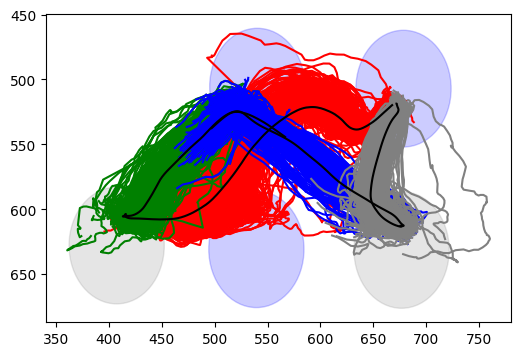

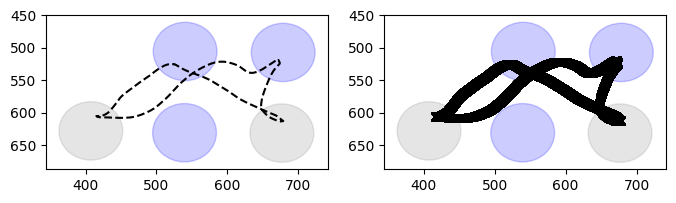

In [4]:
# find task relevant tracking periods, extract times mouse is close to each behavioural port
threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,radius = 45)

## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
fps = 1/np.mean(np.diff(camera_timestamps_df['Time Stamps'].values))
time_filter = 2 #in s
frame_filter = int(time_filter / (1/fps))

#we know when the mouse is close to each port, so find times when the mouse goes from port to port 
start_port,end_port = 5,2
T1_start_ind, T1_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,4,-1,-1)
start_port,end_port = 2,3
T2_start_ind, T2_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,4,5)
start_port,end_port = 3,4
T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,5)
start_port,end_port = 4,5
T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,3)

# find average curves by taking traject lines and make them roughly equivalent by interpolating so they have the same number of trakcing points, then for each point in each trajectory find the average xy position to create an average trajectory line 
a_curve1,a_curve2,a_curve3,a_curve4 = find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer = 10, radius = 45)

# join each curve, join them at the point that they touch, or if they dont touch just join the two ends to each other
new = join_curves(a_curve1, a_curve2,cut = True)
new = join_curves(new, a_curve3,cut = True)
new = join_curves(new, a_curve4,cut = True)
# join the two ends together to make a complete circle
complete_average = join_make_full_circle(new)

#interpolate to make standardspace:
standard_av_curve = resample_curve(complete_average, num_points = 10000)

# shift the start point of the curve so that is the first time the mous eleaves port 5 radius
standard_av_curve = shift_curve_start(standard_av_curve,port_centroids[-1])

# plot this stuff to check it looks okay
plot_av_and_new_standard_line(complete_average,standard_av_curve,radius_used,port_centroids)

# load in the seq colours 
seq_colours = np.load(awake_ppseq_base_path+ r'/analysis_output/reordered_recolored/colors',allow_pickle=True)

In [429]:
def get_percentage_points(resampled_curve, percentages):
    """
    Get the points at specific percentage locations along the resampled curve.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param percentages: List of percentages (0-100) where points should be extracted
    :return: List of (x, y) points corresponding to the given percentages
    """
    num_points = len(resampled_curve)
    indices = [int(p / 100 * (num_points - 1)) for p in percentages]  # Convert percentage to index
    return resampled_curve[indices]

def plot_percentage_interval(resampled_curve, percentages,port_centroids,ax,sequence_name,colour_):
    """
    Plot the full resampled curve and highlight the region between two percentage points.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param percentages: List [start%, end%] defining the highlighted region
    """
    num_points = len(resampled_curve)
    start_idx = int(percentages[0] / 100 * (num_points - 1))
    end_idx = int(percentages[1] / 100 * (num_points - 1))

    # Handle case where interval wraps around (e.g., 97% to 14%)
    if start_idx <= end_idx:
        highlight_indices = range(start_idx, end_idx + 1)
    else:
        highlight_indices = list(range(start_idx, num_points)) + list(range(0, end_idx + 1))

    # Extract x, y coordinates
    x_vals, y_vals = resampled_curve[:, 0], resampled_curve[:, 1]

    # Plot full curve
    ax.plot(x_vals, y_vals, color='black', linewidth=1, label="Full Curve")

    # Highlight section
    highlighted_x = x_vals[list(highlight_indices)]
    highlighted_y = y_vals[list(highlight_indices)]
    ax.plot(highlighted_x, highlighted_y, color=colour_, linewidth=2, label="Highlighted Region")

    # Scatter start and end points
    ax.scatter([x_vals[start_idx], x_vals[end_idx]], 
                [y_vals[start_idx], y_vals[end_idx]], 
                color='blue', zorder=3, label="Start/End Points")

    for index,port_centroid in enumerate(port_centroids):
        circle1 = plt.Circle(port_centroid, radius_used, color='grey', alpha = 0.2)
        ax.add_patch(circle1)
        
    ax.set_title(f"sequence {int(sequence_name)+1}")
        
    ax.invert_yaxis()
    
def find_motif_points(continuous_regions_df, standard_av_curve, port_centroids, seq_colours, num_intermediate_points=5):

    start_end_intermediate = []
    fig, axs = plt.subplots(1, len(continuous_regions_df), figsize=(4 * len(continuous_regions_df), 2))

    for i, row in continuous_regions_df.iterrows():
        buffer_ = 2  # 2% buffer on each side
        start = row.start - buffer_
        end = row.end + buffer_
        
        # Handle circular nature at 100%
        if start < 0:
            start += 100
        if end > 100:
            end -= 100
        
        # Compute percentage points
        if start < end:
            positions = np.linspace(start, end, num_intermediate_points + 2)[1:-1]  # Exclude start and end
        else:  # Wraps around 100%
            positions = np.linspace(0, (100-start)+end, num_intermediate_points + 2)[1:-1]  # Exclude start and end
            positions = start + positions
            positions = [position-100 if position>100 else position for position in positions]
        
        
        intermediate_xy = get_percentage_points(standard_av_curve, positions)
        s_, e_ = get_percentage_points(standard_av_curve, [start, end])
        
        # Plot
        plot_percentage_interval(standard_av_curve, [start, end], port_centroids, axs[i], row.sequence, seq_colours[int(row.sequence) + 1])
        
        # Store results
        start_end_intermediate.append([s_, *intermediate_xy, e_])

    # Create column names dynamically based on number of intermediate points
    columns = ["start_xy"] + [f"intermediate_{i}_xy" for i in range(1, num_intermediate_points + 1)] + ["end_xy"]
    return pd.DataFrame(start_end_intermediate, columns=columns)


#############################################################

def centroid_distance(window, template):
    """
    Compute Euclidean distance between centroids of the window and the template.
    """
    centroid_window = np.mean(window, axis=0)
    centroid_template = np.mean(template, axis=0)
    return euclidean(centroid_window, centroid_template)

def find_similar_segments(tracking, template, threshold, centroid_thresh=3, radius=3):
    """
    Find similar segments with centroid pre-filtering.
    
    Parameters:
        tracking: Nx2 array of (x,y) points.
        template: Mx2 array of template (x,y) points.
        threshold: DTW distance threshold.
        centroid_thresh: Pre-filter threshold on centroid distance.
        radius: DTW radius for fastdtw.
    
    Returns:
        List of matching segment indices.
    """
    tracking = np.array(tracking)
    template = np.array(template)
    M = len(template)
    matches = []

    for start in tqdm(range(len(tracking) - M + 1), desc="Processing segments"):
        window = tracking[start : start + M]

        # Pre-filter: Check centroid distance first
        if centroid_distance(window, template) > centroid_thresh:
            continue  # Skip if centroids are too far apart

        # Run DTW only if centroid distance is low
        distance, _ = fastdtw(window, template, radius=radius, dist=euclidean)
        if distance < threshold:
            matches.append((start, start + M))

    return matches


def find_closest_to_centroid(tracking_, centroid, num_points=100):
    """
    Find the indices of the `num_points` closest points to a given centroid.

    Parameters:
        tracking: Nx2 array of (x, y) points.
        centroid: 1x2 array of the centroid coordinates.
        num_points: Number of closest points to find.

    Returns:
        Indices of the closest points in the tracking array.
    """
    distances = distance.cdist(tracking_, [centroid], metric='euclidean').flatten()
    closest_indices = np.argsort(distances)[:num_points]
    return closest_indices,distances


def process_and_validate_trajectories(tracking, matches, template,add_amount,frame_filter,dist_filter,num_points):
    """
    Process each trajectory by extending, trimming, and validating.

    Parameters:
        tracking: Nx2 array of (x, y) points.
        matches: List of (start, end) indices of matching segments.
        template: Mx2 array of template (x, y) points.
        frame_filter: Maximum allowed length for a trajectory.

    Returns:
        List of processed (start, end) indices for valid trajectories.
    """
    processed_trajectories = []

    # Define the start and end points from the template
    start_centroid = template[0]
    end_centroid = template[-1]

    for start, end in matches:
        # Step 1: Extend the trajectory
        start = start - add_amount
        end = end + add_amount
        extended_trajectory = tracking[start:end]
        # Step 2: Find closest points to the start and end centroids in teh first and l;ast 30% of the trajectory
        closest_start_indices,start_distances = find_closest_to_centroid(extended_trajectory[0:int(abs(len(extended_trajectory)*0.3))], start_centroid, num_points)
        closest_end_indices,end_distances = find_closest_to_centroid(extended_trajectory[int(abs(len(extended_trajectory)*0.6))::], end_centroid, num_points)
        
        # if closest is too far away then skip
        if start_distances[np.min(closest_start_indices)] > dist_filter:
            continue
        if end_distances[np.max(closest_end_indices)] > dist_filter:
            continue
        
        # Step 3: Trim the trajectory
        trimmed_start = start + np.min(closest_start_indices)
        trimmed_end =start + int(abs(len(extended_trajectory)*0.6)) + np.max(closest_end_indices)
    
        
        # Step 4: Validate length
        if (trimmed_end-trimmed_start) > frame_filter:
            continue  # Skip trajectories longer than frame_filter
        
        # step 5, Add valid trajectory indices to the final list
        processed_trajectories.append([trimmed_start,trimmed_end])

    return processed_trajectories

def remove_overlaps(start_end_inds):
    # Sort by start index to make overlap checking easier
    start_end_inds.sort()

    to_remove = []

    for i in range(len(start_end_inds)):
        for j in range(i + 1, len(start_end_inds)):
            start1, end1 = start_end_inds[i]
            start2, end2 = start_end_inds[j]

            # Check if there's an overlap of more than 5 indices
            if start2 <= end1 and end2 >= start1:  # They overlap
                overlap = min(end1, end2) - max(start1, start2) + 1
                if overlap > 5:
                    # Remove the longer one
                    if end1 - start1 > end2 - start2:
                        to_remove.append(j)
                    else:
                        to_remove.append(i)

    # Remove duplicates from the to_remove list and create the new list
    to_remove = sorted(set(to_remove), reverse=True)
    for index in to_remove:
        start_end_inds.pop(index)

    return start_end_inds

###########################################################


Processing segments: 100%|██████████| 164676/164676 [01:41<00:00, 1624.10it/s] 


285


Processing segments: 100%|██████████| 164676/164676 [01:52<00:00, 1457.37it/s] 


289


Processing segments: 100%|██████████| 164676/164676 [00:51<00:00, 3201.31it/s] 


330


Processing segments: 100%|██████████| 164676/164676 [02:04<00:00, 1323.24it/s] 


389


Processing segments: 100%|██████████| 164676/164676 [04:20<00:00, 631.69it/s]  


480


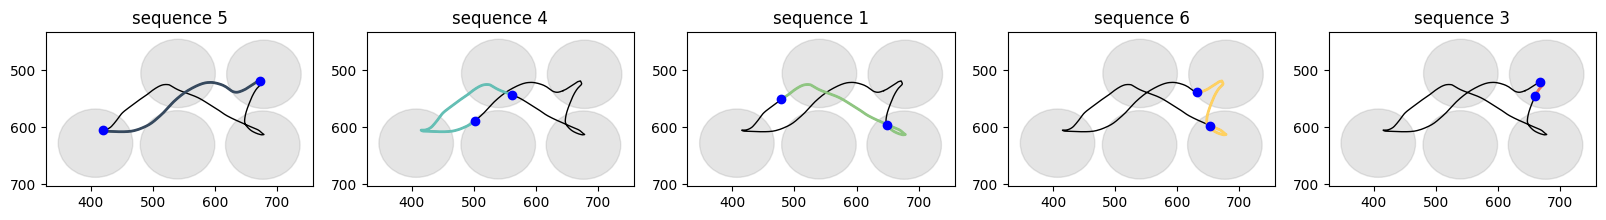

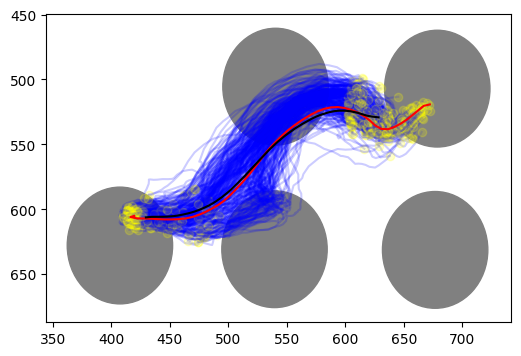

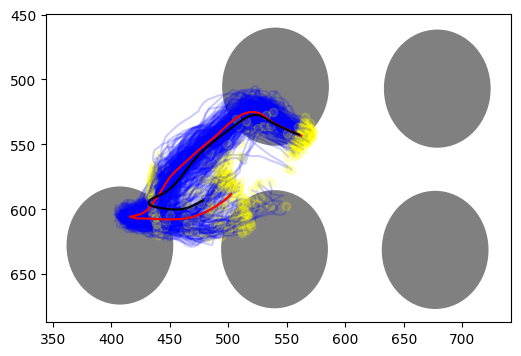

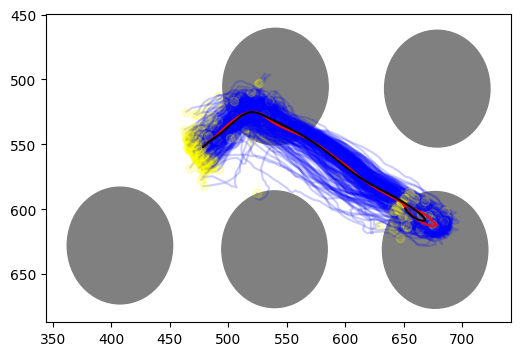

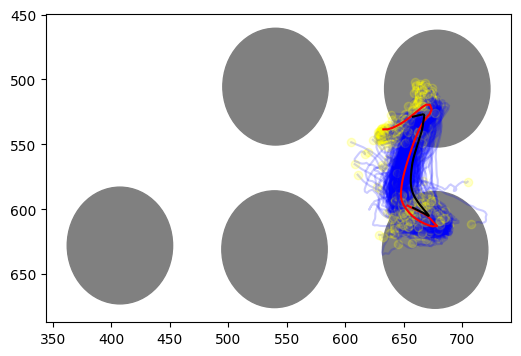

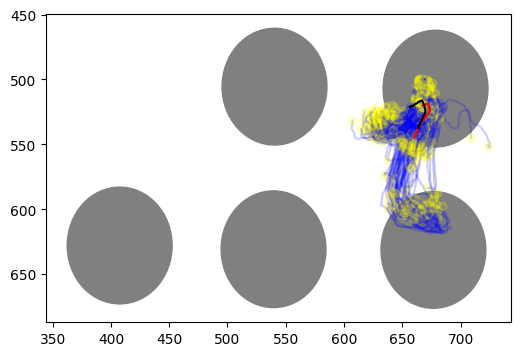

In [671]:

# next define the regions of each motif 
motif_start_ends_df = find_motif_points(continuous_regions_df,standard_av_curve,port_centroids,seq_colours,num_intermediate_points=50)

# now take these start and end points of each motif to find all motif examples:
motif_start_ends = []
for i in range(len(motif_start_ends_df)):

    points = []
    for column in list(motif_start_ends_df):
        row = motif_start_ends_df[(f'{column}')][i]
        points += [row]
        
    #convert to xy coords
    full_tracking_coords = []
    for ind_,item in enumerate(current_x):
        full_tracking_coords += [[item,current_y[ind_]]]
        
    centroid_distance_threshold = 1000000  # You need to set an appropriate threshold based on your data.
    radius_threshold = 25
    similar_segments = find_similar_segments(full_tracking_coords, points, centroid_distance_threshold,radius_threshold)
    ## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
    time_filter = 6 #in s
    # minimum distance from start/end centroid
    dist_filter = 70
    # number of closest points to start/end centroid to find and chose from
    num_points = 3
    # number of points to add to the start and end of the trajectory
    add_start_end = 5
    valid_trajectories = process_and_validate_trajectories(full_tracking_coords, similar_segments, points,add_start_end,int(time_filter / (1/fps)),dist_filter,num_points)

    # then remove any duplicates:
    valid_trajectories_filtered = remove_overlaps(valid_trajectories)

    fig, ax = plt.subplots(1, 1,figsize=(6, 4))
    for index,port_centroid in enumerate(port_centroids):
        circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
        ax.add_patch(circle1)

    trajects = []
    for ind in valid_trajectories_filtered:
        traject = full_tracking_coords[ind[0]:ind[1]]
        trajects += [traject]
        x = [point[0] for point in traject]
        y = [point[1] for point in traject]
        ax.plot(x,y,'-', color = 'blue', alpha = 0.2)
        ax.plot(x[0],y[0],'o', color = 'yellow', alpha = 0.2)
        ax.plot(x[-1],y[-1],'o', color = 'yellow', alpha = 0.2)

    x = [point[0] for point in points]
    y = [point[1] for point in points]
    ax.plot(x,y,'-', color = 'red', alpha = 1)

    av_of_found = interpolate_to_longest_and_find_average_curve(trajects,500)
    x = [point[0] for point in av_of_found]
    y = [point[1] for point in av_of_found]
    ax.plot(x,y,'-', color = 'k', alpha = 1)
        
    ax.invert_yaxis()

    print(len(valid_trajectories_filtered))
    
    motif_start_ends += [valid_trajectories_filtered]

In [672]:
motif_start_ends

[[[1127, 1188],
  [4146, 4207],
  [9095, 9156],
  [9676, 9737],
  [13442, 13500],
  [14502, 14563],
  [14933, 14994],
  [15692, 15753],
  [15972, 16033],
  [16332, 16393],
  [16834, 16895],
  [17145, 17204],
  [17396, 17457],
  [17688, 17749],
  [17985, 18046],
  [18248, 18309],
  [18510, 18571],
  [18706, 18767],
  [18896, 18957],
  [20884, 20939],
  [21263, 21324],
  [21595, 21656],
  [22225, 22286],
  [22748, 22809],
  [23370, 23431],
  [23658, 23719],
  [24003, 24064],
  [24378, 24439],
  [24774, 24835],
  [25109, 25169],
  [25396, 25457],
  [25695, 25756],
  [28643, 28704],
  [28870, 28931],
  [29137, 29198],
  [29389, 29450],
  [29696, 29757],
  [29929, 29990],
  [30129, 30190],
  [30383, 30444],
  [30681, 30742],
  [30958, 31019],
  [31384, 31445],
  [31689, 31749],
  [31865, 31926],
  [32071, 32132],
  [32470, 32531],
  [32777, 32838],
  [33932, 33993],
  [34869, 34930],
  [35791, 35852],
  [36196, 36257],
  [36435, 36496],
  [36902, 36963],
  [37467, 37528],
  [37713, 37774],


[[3407, 3468],
 [4096, 4138],
 [6247, 6281],
 [9045, 9091],
 [9323, 9368],
 [9376, 9406],
 [9529, 9575],
 [9582, 9632],
 [10597, 10658],
 [10695, 10750],
 [13389, 13444],
 [14434, 14480],
 [14794, 14831],
 [14829, 14876],
 [14884, 14923],
 [15644, 15690],
 [15863, 15920],
 [16185, 16246],
 [16249, 16310],
 [16306, 16349],
 [16713, 16769],
 [17042, 17103],
 [17100, 17147],
 [17302, 17362],
 [17563, 17598],
 [17596, 17655],
 [17851, 17887],
 [17894, 17949],
 [18139, 18173],
 [18186, 18229],
 [18481, 18514],
 [18673, 18714],
 [18861, 18901],
 [19080, 19126],
 [20852, 20889],
 [21219, 21261],
 [21549, 21584],
 [22183, 22221],
 [22436, 22474],
 [22474, 22513],
 [22703, 22746],
 [22961, 23004],
 [23008, 23053],
 [23087, 23126],
 [23311, 23357],
 [23531, 23591],
 [23848, 23904],
 [23917, 23955],
 [23952, 24001],
 [24196, 24232],
 [24252, 24302],
 [24311, 24365],
 [24570, 24619],
 [24664, 24713],
 [24719, 24765],
 [24918, 24960],
 [25025, 25084],
 [25263, 25306],
 [25312, 25373],
 [25593, 2564

In [ ]:
# then find the variability..deviation from trajectory, 

# average speed

# speed variability, 
 






In [320]:
### this approach doesnt seem to be working...
# I think a simple simple way to do this would actually be to divide the whole area up into a logicval grid where each area has a start and end port assisocated with it
# then use the port to port boundaries to find longer trajectories 
## then trim these down to motif trajectories by using the start and end points of each motif 




In [470]:
import numpy as np

def compute_perpendicular_lines(ideal_points, lengths):
    """Compute the perpendicular lines for the ideal path."""
    lines = []
    for i, point in enumerate(ideal_points):
        if i == 0:
            length = lengths['start']
            direction = ideal_points[i + 1] - point
        elif i == len(ideal_points) - 1:
            length = lengths['end']
            direction = point - ideal_points[i - 1]
        else:
            length = lengths['intermediate']
            direction = ideal_points[i + 1] - ideal_points[i - 1]

        # Compute the perpendicular vector
        perp_direction = np.array([-direction[1], direction[0]])
        perp_direction = perp_direction / np.linalg.norm(perp_direction)  # Normalize
        line_start = point + perp_direction * (length / 2)
        line_end = point - perp_direction * (length / 2)
        lines.append((line_start, line_end))
    return lines

def find_trajectories_optimized(tracking_data, ideal_points, lines, direction_window=5, tolerance=1e-3):
    """Optimized function to find matching trajectories in the tracking data with a progress bar."""
    trajectories = []
    current_trajectory = []

    # Precompute normalized line directions to avoid recalculating them repeatedly
    line_directions = [
        (line_end - line_start) / np.linalg.norm(line_end - line_start)
        for line_start, line_end in lines
    ]

    # Iterate through tracking data with a progress bar
    for i in tqdm(range(len(tracking_data)), desc="Finding Trajectories", unit="step"):
        if i < direction_window:
            continue  # Skip until we have enough points to compute directionality

        # Compute the tracking directionality using the most recent points
        recent_points = tracking_data[i - direction_window:i]
        direction = recent_points[-1] - recent_points[0]
        direction = direction / np.linalg.norm(direction)  # Normalize direction

        for j, (line_start, line_end) in enumerate(lines):
            if j < len(current_trajectory):
                continue  # Skip lines already matched in the current trajectory

            # Quickly filter out points that are not within a bounding box of the line
            if not (min(line_start[0], line_end[0]) - tolerance <= tracking_data[i, 0] <= max(line_start[0], line_end[0]) + tolerance and
                    min(line_start[1], line_end[1]) - tolerance <= tracking_data[i, 1] <= max(line_start[1], line_end[1]) + tolerance):
                continue

            # Check directionality (dot product with the precomputed line direction)
            dot_product = np.dot(direction, line_directions[j])
            if dot_product < 0:  # Moving in the opposite direction
                continue

            # Check if the tracking point is close enough to the line (vectorized cross product)
            line_vector = line_end - line_start
            line_to_point = tracking_data[i] - line_start
            cross_product = np.cross(line_vector, line_to_point)

            # Check if the point is close enough to the line
            if abs(cross_product / np.linalg.norm(line_vector)) < tolerance:
                current_trajectory.append(i)
                break

        # If the current trajectory has matched all ideal points, store it
        if len(current_trajectory) == len(ideal_points):
            trajectories.append(current_trajectory)
            current_trajectory = []

    return trajectories

#convert to xy coords
full_tracking_coords = []
for ind_,item in enumerate(current_x):
    full_tracking_coords += [[item,current_y[ind_]]]
    
## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
# fps = 1/np.mean(np.diff(camera_timestamps_df['Time Stamps'].values))
# time_filter = 4 #in s
# frame_filter = int(time_filter / (1/fps))

for i in range(len(motif_start_ends_df)):
    points = []
    for column in list(motif_start_ends_df):
        row = motif_start_ends_df[(f'{column}')][i]
        points += [row]

    lengths = {'start': 200, 'intermediate': 200, 'end': 200}
    lines = compute_perpendicular_lines(points, lengths)
    trajectories = find_trajectories_optimized(np.array(full_tracking_coords), points, lines, direction_window=5, tolerance = 4)

    print(len(trajectories))
    break

Finding Trajectories:  96%|█████████▌| 158006/164727 [00:01<00:00, 107625.38step/s]C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_23404\3566702063.py:44: RuntimeWarning: invalid value encountered in divide
  direction = direction / np.linalg.norm(direction)  # Normalize direction
Finding Trajectories: 100%|██████████| 164727/164727 [00:01<00:00, 92301.93step/s] 

414


414


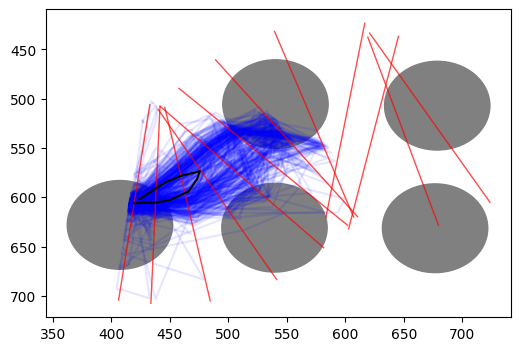

In [471]:
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
for index,port_centroid in enumerate(port_centroids):
    circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
    ax.add_patch(circle1)

trajects = []
for inds in trajectories:
    traject = np.array(full_tracking_coords)[inds]
    trajects += [traject]
    x = [point[0] for point in traject]
    y = [point[1] for point in traject]
    ax.plot(x,y,'-', color = 'blue', alpha = 0.1)
        
for line_start, line_end in lines:
    x_values = [line_start[0], line_end[0]]
    y_values = [line_start[1], line_end[1]]
    plt.plot(x_values, y_values, color='red', linestyle='-', linewidth=1, label='Perpendicular Line', alpha = 0.7)



av_of_found = interpolate_to_longest_and_find_average_curve(trajects,1000)
x = [point[0] for point in av_of_found]
y = [point[1] for point in av_of_found]
ax.plot(x,y,'-', color = 'k', alpha = 1)

ax.invert_yaxis()
print(len(trajectories))

In [468]:
len(trajectories)

3398

In [467]:
full_tracking_coords

[[366.0610656738281, 584.2506713867188],
 [365.4916076660156, 585.1483154296875],
 [364.3154602050781, 585.561767578125],
 [363.2419128417969, 585.3045043945312],
 [362.5351257324219, 584.5206909179688],
 [361.75738525390625, 583.8336181640625],
 [358.1661071777344, 583.9848022460938],
 [355.9764099121094, 582.7902221679688],
 [353.66650390625, 580.9142456054688],
 [351.624755859375, 577.533447265625],
 [351.95379638671875, 574.1221923828125],
 [351.56329345703125, 573.7626953125],
 [351.6646728515625, 575.5214233398438],
 [352.64495849609375, 577.6873779296875],
 [352.98345947265625, 579.09521484375],
 [354.7115173339844, 577.9529418945312],
 [357.326904296875, 574.2119750976562],
 [359.53118896484375, 570.5145263671875],
 [364.1505432128906, 566.692626953125],
 [369.0614929199219, 562.9442138671875],
 [372.3345031738281, 560.0086669921875],
 [374.4647216796875, 556.8135375976562],
 [377.4209899902344, 554.5160522460938],
 [378.8446044921875, 554.0878295898438],
 [378.6395263671875, 5

In [358]:
def closest_point_on_curve(curve, port):
    """
    Finds the closest point on the curve to the given port.
    
    curve: List of (x, y) tuples representing the curve (circular path).
    port: (x, y) tuple representing the port location.
    
    Returns a tuple (closest_point, index) where:
      - closest_point is the (x, y) closest point on the curve.
      - index is the index of the closest point in the curve.
    """
    distances = [distance.euclidean(port, point) for point in curve]
    closest_idx = np.argmin(distances)
    return curve[closest_idx], closest_idx

def associate_ports_with_curve(curve, ports):
    """
    Associates each port with the closest deliberate visit on the curve, moving chronologically.
    
    curve: List of (x, y) tuples representing the curve (circular path).
    ports: List of (x, y) tuples representing the port locations in the order of visits.
    
    Returns a list of (port, closest_point_on_curve, percentage) tuples where:
      - closest_point_on_curve is the closest (x, y) point on the curve.
      - percentage is the location of the closest point as a percentage of the curve length.
    """
    visited_ports = []
    percentage_locations = []
    curve_length = len(curve)  # Total number of points on the curve
    
    for port in ports:
        # Find the closest point to the current port and its index
        closest_point, closest_idx = closest_point_on_curve(curve, port)
        
        # Calculate the percentage position along the curve
        percentage = (closest_idx / curve_length) * 100
        
        # Add the port, closest point, and percentage to the list
        visited_ports.append(closest_point)
        percentage_locations.append(percentage)
    
    return visited_ports,percentage_locations

def find_closest_ports(percentage_locations, segments):
    """
    Finds the closest ports (excluding the first port) that enclose each segment:
      - Closest port to the segment's start.
      - Closest port to the segment's end.
      - Adjusts the start port if it matches the end port.
    
    percentage_locations: List of percentages representing port positions on the curve.
                          Ports are labeled 1, 2, 3, 4, 5 in the order of appearance.
    segments: List of (start_percentage, end_percentage) tuples representing segments.
    
    Returns a list of (segment, (start_port_idx, end_port_idx)) tuples representing the
    indices of the closest ports.
    """
    results = []
    num_ports = len(percentage_locations)

    for start, end in segments:
        start_port_idx = None
        end_port_idx = None

        # Find the closest port to the start (ignoring the first port)
        min_start_diff = float("inf")
        for i in range(1, num_ports):  # Skip the first port
            diff = abs(percentage_locations[i] - start)
            if diff < min_start_diff:
                min_start_diff = diff
                start_port_idx = i

        # Find the closest port to the end (ignoring the first port)
        min_end_diff = float("inf")
        for i in range(1, num_ports):  # Skip the first port
            diff = abs(percentage_locations[i] - end)
            if diff < min_end_diff:
                min_end_diff = diff
                end_port_idx = i

        # Ensure start and end ports are different
        if start_port_idx == end_port_idx:
            start_port_idx = (end_port_idx - 1) % num_ports  # Move one port earlier
            if start_port_idx == 0:  # Wrap around to port 4 if it ends up being 0
                start_port_idx = 4

        results.append([start_port_idx, end_port_idx])

    return results

[[4, 1], [1, 2], [2, 3], [3, 4], [3, 4]]


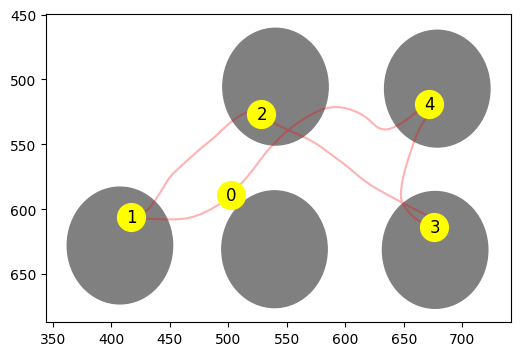

In [361]:
# define 'port' positions on the average curve, ie. the closest point on the trajectory to each port...when the mouse would have poked its nose 
visited_ports_locations,visited_ports_prcnt = associate_ports_with_curve(standard_av_curve,port_centroids)

## plot this for good measure
fig, ax = plt.subplots(1, 1,figsize=(6, 4))
for index,port_centroid in enumerate(port_centroids):
    circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
    ax.add_patch(circle1)
x = [point[0] for point in standard_av_curve]
y = [point[1] for point in standard_av_curve]
ax.plot(x,y,'-', color = 'red', alpha = 0.3)
for i, point in enumerate(visited_ports_locations):
    ax.plot(point[0], point[1], 'o',c = 'yellow', markersize=20)
    ax.text(point[0]-4, point[1]+4, str(i), fontsize=12)
ax.invert_yaxis()

# find reasonable port to port approximations for the motifs
segments= []
for i,row in continuous_regions_df.iterrows():
    segments.append((row.start,row.end))

start_end_port = find_closest_ports(visited_ports_prcnt, segments)
print(start_end_port)

# find these port-port trajectories and extend them, then trim them down to motif trajectories by using the start and end points of each motif


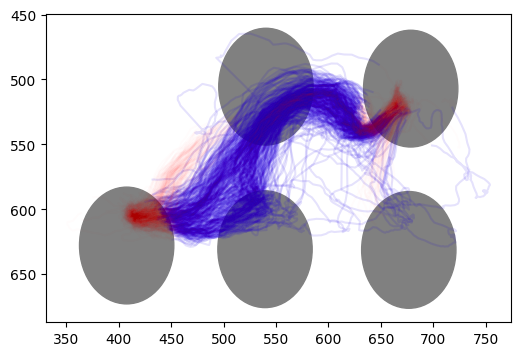

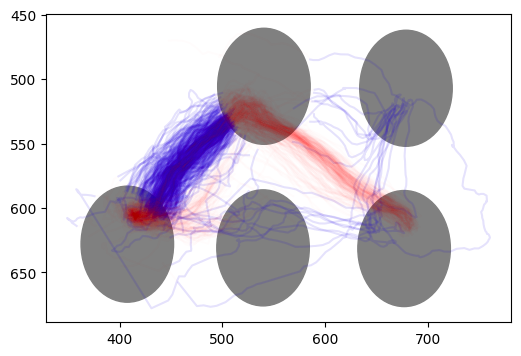

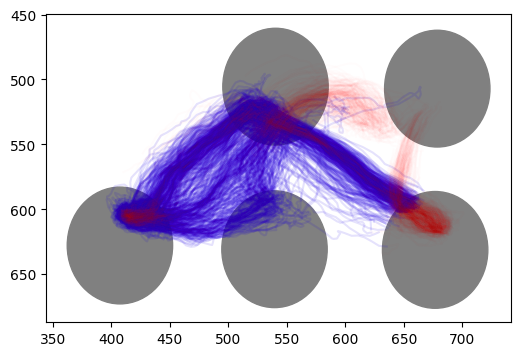

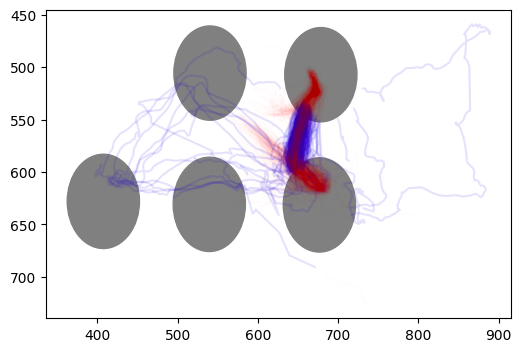

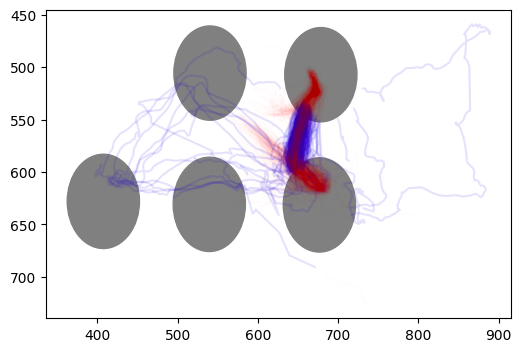

In [392]:
# recalculate threshold breaks with a larger radisu 
new_threshold_breaks,_,_,_,_ = find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,radius = 60)

# set time filter 
time_filter = 4 #in s
for start,end in start_end_port:
    start_port,end_port = start+1,end+1
    start_ind, end_ind = extract_port_to_port_trajetories(start_port,end_port,int(time_filter / (1/fps)),new_threshold_breaks,-1,-1,-1)

    
    fig, ax = plt.subplots(1, 1,figsize=(6, 4))
    for index,port_centroid in enumerate(port_centroids):
        circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
        ax.add_patch(circle1)


    #convert to xy coords
    coords = []
    for ind_,item in enumerate(current_x):
        coords += [[item,current_y[ind_]]]

    for i in range(len(start_ind)):
        traject = coords[start_ind[i]:end_ind[i]]
        x = [point[0] for point in traject]
        y = [point[1] for point in traject]
        ax.plot(x,y,'-', color = 'blue', alpha = 0.1)
        
        
    start_ind = np.array(start_ind) - 30
    end_ind = np.array(end_ind) + 30
            
    for i in range(len(start_ind)):
        traject = coords[start_ind[i]:end_ind[i]]
        x = [point[0] for point in traject]
        y = [point[1] for point in traject]
        ax.plot(x,y,'-', color = 'red', alpha = 0.01)
        
    
    ax.invert_yaxis()
    


In [341]:
def find_best_enclosing_ports(percentage_locations, segments):
    """
    Finds the best port combination that envelopes each segment in the specified order.
    
    percentage_locations: List of percentages representing port positions on the curve.
                          Ports are labeled 1, 2, 3, 4, 5 in the order of appearance.
    segments: List of (start_percentage, end_percentage) tuples representing segments.
    
    Returns a list of (segment, enclosing_combination) tuples where:
      - enclosing_combination is one of ('5-2', '5-3', '3-5', '4-2', '4-3').
    """
    port_order = [1, 2, 3, 4, 5]  # Port labels
    combinations = {
        "5-2": (5, 2),
        "5-3": (5, 3),
        "3-5": (3, 5),
        "4-2": (4, 2),
        "4-3": (4, 3),
        "2-5": (2, 5),
        "5-4": (5, 4),
    }
    
    results = []

    for start, end in segments:
        best_combination = None

        for combo_name, (start_port, end_port) in combinations.items():
            start_port_idx = port_order.index(start_port)
            end_port_idx = port_order.index(end_port)

            # Ensure the combination goes in the correct direction
            if start_port_idx < end_port_idx:
                start_percentage = percentage_locations[start_port_idx]
                end_percentage = percentage_locations[end_port_idx]

                # Check if the combination envelops the segment
                if start_percentage <= start and end_percentage >= end:
                    best_combination = combo_name
                    break  # Take the first valid combination (you can change this logic if needed)

        results.append(((start, end), best_combination))

    return results

segments= []
for i,row in continuous_regions_df.iterrows():
    segments.append((row.start,row.end))

results = find_best_enclosing_ports(visited_ports_prcnt, segments)

for segment, enclosing_combination in results:
    print(f"Segment {segment}:")
    if enclosing_combination:
        print(f"  Enclosed by combination: {enclosing_combination}")
    else:
        print(f"  No valid enclosing combination found")


Segment (97.42734635540734, 34.49261553120533):
  Enclosed by combination: 3-5
Segment (25.297760838494522, 58.69461648404002):
  No valid enclosing combination found
Segment (49.59504525964745, 82.0867079561696):
  Enclosed by combination: 2-5
Segment (77.08432586946165, 99.61886612672701):
  No valid enclosing combination found
Segment (93.37779895188186, 94.14006669842783):
  Enclosed by combination: 3-5


In [343]:
segments

[(97.42734635540734, 34.49261553120533),
 (25.297760838494522, 58.69461648404002),
 (49.59504525964745, 82.0867079561696),
 (77.08432586946165, 99.61886612672701),
 (93.37779895188186, 94.14006669842783)]

In [333]:
def find_ports_encompassing_segments(visited_ports, percentage_locations, segments):
    """
    Finds the ports that encompass each segment (one before the start and one after the end).
    
    visited_ports: List of (x, y) tuples representing the closest points on the curve for each port.
    percentage_locations: List of percentages corresponding to each port's closest point on the curve.
    segments: List of (start_percentage, end_percentage) tuples representing segments.
    
    Returns a list of (segment, start_port, end_port) tuples where:
      - start_port is the closest port just before the segment starts.
      - end_port is the closest port just after the segment ends.
    """
    results = []
    # Combine ports and their percentages for easier manipulation
    ports_with_percentages = list(zip(visited_ports, percentage_locations))
    # Ensure they are sorted by percentage
    ports_with_percentages.sort(key=lambda x: x[1])  # Sort by percentage

    for start, end in segments:
        if start <= end:
            # Standard segment (no wrapping around)
            start_port = max((p for p in ports_with_percentages if p[1] <= start), key=lambda p: p[1], default=None)
            end_port = min((p for p in ports_with_percentages if p[1] >= end), key=lambda p: p[1], default=None)
        else:
            # Wrapping segment (e.g., 95% to 10%)
            start_port = max((p for p in ports_with_percentages if p[1] <= start), key=lambda p: p[1], default=None)
            end_port = min((p for p in ports_with_percentages if p[1] >= end or p[1] <= end), key=lambda p: p[1], default=None)

        results.append(((start, end), start_port, end_port))
    
    return results




segments= []
for i,row in continuous_regions_df.iterrows():
    segments.append((row.start,row.end))

results = find_ports_encompassing_segments(visited_ports_locations, visited_ports_prcnt, segments)

for segment, start_port, end_port in results:
    print(f"Segment {segment}:")
    if start_port:
        print(f"  Start Port: {start_port[0]} at {start_port[1]:.2f}%")
    else:
        print(f"  Start Port: None")
    if end_port:
        print(f"  End Port: {end_port[0]} at {end_port[1]:.2f}%")
    else:
        print(f"  End Port: None")




Segment (97.42734635540734, 34.49261553120533):
  Start Port: [671.80804539 518.7436711 ] at 95.50%
  End Port: [502.16766943 588.80675977] at 23.36%
Segment (25.297760838494522, 58.69461648404002):
  Start Port: [502.16766943 588.80675977] at 23.36%
  End Port: [675.94692119 613.45901738] at 79.57%
Segment (49.59504525964745, 82.0867079561696):
  Start Port: [416.5447853  606.17910584] at 35.66%
  End Port: [671.80804539 518.7436711 ] at 95.50%
Segment (77.08432586946165, 99.61886612672701):
  Start Port: [528.14821453 526.76709226] at 55.50%
  End Port: None
Segment (93.37779895188186, 94.14006669842783):
  Start Port: [675.94692119 613.45901738] at 79.57%
  End Port: [671.80804539 518.7436711 ] at 95.50%


In [334]:
visited_ports_prcnt

[23.36, 35.66, 55.50000000000001, 79.57, 95.5]

In [332]:
segments

[(97.42734635540734, 34.49261553120533),
 (25.297760838494522, 58.69461648404002),
 (49.59504525964745, 82.0867079561696),
 (77.08432586946165, 99.61886612672701),
 (93.37779895188186, 94.14006669842783)]

In [425]:
##### finding trajectories

def is_within_radius_np(points, center, radius):
    """Efficiently checks if points are within a given radius of a center using NumPy."""
    points = np.array(points)
    center = np.array(center)
    return np.linalg.norm(points - center, axis=1) <= radius

def find_transition_times(start_center, end_center, intermediate_centers, trajectory, frame_filter, radius_start_end, radius_intermediate,add_points):
    """
    Finds unique trajectory transitions by scanning chronologically.
    
    - Each transition starts when tracking enters the start radius.
    - If tracking exits & re-enters the start radius, restart search.
    - The transition must reach the end radius and pass all intermediates.
    - The actual start & end points are adjusted to the closest positions to their centers.
    - Adds 20 points to the start and end of the trajectory before trimming.
    """
    trajectory = np.array(trajectory)  # Convert trajectory to NumPy array for faster operations
    transitions = []
    
    # Compute masks for start, end, and intermediate zones
    start_mask = is_within_radius_np(trajectory, start_center, radius_start_end)
    end_mask = is_within_radius_np(trajectory, end_center, radius_start_end)
    intermediate_masks = [is_within_radius_np(trajectory, center, radius_intermediate) for center in intermediate_centers]

    searching_for_start = True
    start_idx = None
    
    for i in tqdm(range(len(trajectory)), desc="Processing Trajectories"):
        if searching_for_start:
            # Look for an entry into the start radius
            if start_mask[i] and (i == 0 or not start_mask[i - 1]):  # Entry detected
                start_idx = i
                searching_for_start = False  # Now looking for a valid transition
        else:
            # Check if it re-enters the start radius before reaching the end → Discard and restart
            if i > start_idx and start_mask[i] and not start_mask[i - 1]:
                searching_for_start = True  # Restart search
                start_idx = None
                continue

            # Look for an end point within frame_filter
            if end_mask[i] and (i - start_idx) <= frame_filter:
                # Continue tracking within the end radius to find the closest point before exit
                exit_idx = i
                # while exit_idx + 1 < len(trajectory) and end_mask[exit_idx + 1]:
                #     exit_idx += 1  # Move forward while inside the end radius
                
                # Check if all intermediate areas were visited at least once
                passed_intermediates = np.array([np.any(mask[start_idx:exit_idx]) for mask in intermediate_masks])
                
                if passed_intermediates.all():  # Must have passed through all intermediates
                    # Add points before the start and after the end
                    extended_start_idx = max(0, start_idx - add_points)
                    extended_end_idx = min(len(trajectory) - 1, exit_idx + add_points)
                    
                    # # Trim to the closest start & end points within the radius
                    # start_candidates = np.where(start_mask[extended_start_idx:exit_idx])[0] + extended_start_idx
                    # end_candidates = np.where(end_mask[start_idx:extended_end_idx])[0] + start_idx
                    
                    # if len(start_candidates) == 0 or len(end_candidates) == 0:
                    #     continue  # Skip if no valid start or end candidates found

                    # closest_start = start_candidates[np.argmin(np.linalg.norm(trajectory[start_candidates] - np.array(start_center), axis=1))]
                    # closest_end = end_candidates[np.argmin(np.linalg.norm(trajectory[end_candidates] - np.array(end_center), axis=1))]
                    
                    # transitions.append((closest_start, closest_end))
                    transitions.append((extended_start_idx, extended_end_idx))
                    searching_for_start = True  # Restart search for next valid transition
                    start_idx = None  # Reset for next search

    return transitions



##### filtering of trajectories

def is_within_radius_np(points, center, radius):
    """Efficiently checks if points are within a given radius of a center using NumPy."""
    points = np.array(points)
    center = np.array(center)
    return np.linalg.norm(points - center, axis=1) <= radius

def precompute_segments(start_center, end_center, intermediate_centers):
    """
    Precomputes the vectors and lengths of the line segments forming the ideal path.
    """
    ideal_points = np.array([start_center] + intermediate_centers + [end_center])
    segment_starts = ideal_points[:-1]
    segment_ends = ideal_points[1:]
    segment_vectors = segment_ends - segment_starts
    segment_lengths_sq = np.einsum('ij,ij->i', segment_vectors, segment_vectors)  # Squared lengths

    return segment_starts, segment_ends, segment_vectors, segment_lengths_sq

def batch_point_line_distance(points, segment_starts, segment_ends, segment_vectors, segment_lengths_sq):
    """
    Efficiently computes the minimum distance from a batch of points to multiple line segments.
    """
    points = np.array(points)[:, None, :]  # Expand dims for broadcasting
    segment_starts = segment_starts[None, :, :]  # Shape (1, num_segments, 2)
    segment_ends = segment_ends[None, :, :]
    segment_vectors = segment_vectors[None, :, :]
    segment_lengths_sq = segment_lengths_sq[None, :]  # Shape (1, num_segments)

    point_vectors = points - segment_starts
    t = np.sum(point_vectors * segment_vectors, axis=2) / segment_lengths_sq  # Projection factor
    t = np.clip(t, 0, 1)  # Keep in [0,1] range

    projections = segment_starts + t[:, :, None] * segment_vectors  # Compute projection points
    distances = np.linalg.norm(points - projections, axis=2)  # Compute Euclidean distances

    return np.min(distances, axis=1)  # Get the minimum distance to any segment for each point

def trajectory_within_bounds_fast(trajectory, segment_starts, segment_ends, segment_vectors, segment_lengths_sq, max_deviation=100):
    """
    Fast check if all trajectory points stay within max_deviation from the ideal path.
    Uses batch distance computation for efficiency.
    """
    min_distances = batch_point_line_distance(trajectory, segment_starts, segment_ends, segment_vectors, segment_lengths_sq)
    return np.all(min_distances <= max_deviation)  # True if all points stay within the threshold

def clean_up_trajectories(transitions, trajectory, start_center, end_center, intermediate_centers, max_deviation=100):
    """
    Removes trajectories that stray too far from the ideal path, using fast batch processing.
    """
    segment_starts, segment_ends, segment_vectors, segment_lengths_sq = precompute_segments(start_center, end_center, intermediate_centers)
    cleaned_transitions = []

    for start_idx, end_idx in tqdm(transitions, desc="Cleaning Trajectories"):
        traj_segment = trajectory[start_idx:end_idx + 1]  # Extract trajectory segment
        
        if trajectory_within_bounds_fast(traj_segment, segment_starts, segment_ends, segment_vectors, segment_lengths_sq, max_deviation):
            cleaned_transitions.append((start_idx, end_idx))  # Keep valid trajectories
    
    return cleaned_transitions


In [ ]:
def trim_based_on_directionality(trajectory, start_idx, end_idx, start_center, end_center, example_start_end):
    """
    Trims the start and end points based on directionality.
    The closest point must be moving in roughly the same direction as the example trajectory.
    """
    def check_directionality(trajectory, idx, ref_direction, window_size=5):
        """ Check if the trajectory at idx is moving in the same direction as the reference direction. """
        window_start = max(0, idx - window_size)
        window_end = min(len(trajectory), idx + window_size)
        trajectory_segment = trajectory[window_start:window_end]
        
        # Calculate the local movement direction as the difference between the points in the window
        direction_vectors = trajectory_segment[1:] - trajectory_segment[:-1]
        
        # Check if the average direction is within the 180 degree radius
        avg_direction = np.mean(direction_vectors, axis=0)
        dot_product = np.dot(ref_direction, avg_direction)
        
        return dot_product > 0  # This ensures the directions are within 180 degrees

    # Direction vectors for the example start-to-intermediate direction and end-to-intermediate direction
    example_start_dir = trajectory[example_start_end[1]] - trajectory[example_start_end[0]]
    example_end_dir = trajectory[example_start_end[-1]] - trajectory[example_start_end[-2]]
    
    # Trim start based on directionality
    start_candidates = np.where(is_within_radius_np(trajectory, start_center, np.linalg.norm(start_center - trajectory[start_idx])))[0]
    closest_start = None
    for candidate in start_candidates:
        if check_directionality(trajectory, candidate, example_start_dir):
            closest_start = candidate
            break
    
    # Trim end based on directionality
    end_candidates = np.where(is_within_radius_np(trajectory, end_center, np.linalg.norm(end_center - trajectory[end_idx])))[0]
    closest_end = None
    for candidate in end_candidates:
        if check_directionality(trajectory, candidate, example_end_dir):
            closest_end = candidate
            break
    
    return closest_start, closest_end

Processing Trajectories: 100%|██████████| 164727/164727 [00:00<00:00, 281934.36it/s]


203


Processing Trajectories: 100%|██████████| 164727/164727 [00:02<00:00, 60293.09it/s]


84


Processing Trajectories: 100%|██████████| 164727/164727 [00:00<00:00, 222679.89it/s]


82


Processing Trajectories: 100%|██████████| 164727/164727 [00:04<00:00, 40271.47it/s]


46


Processing Trajectories: 100%|██████████| 164727/164727 [00:01<00:00, 94453.80it/s] 


112


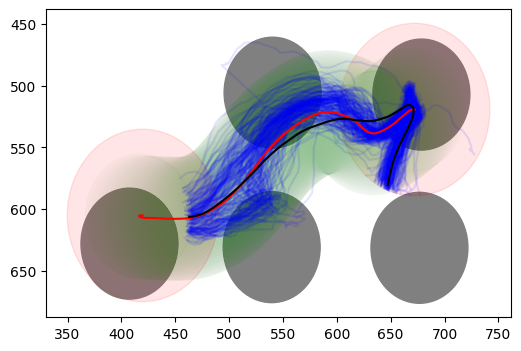

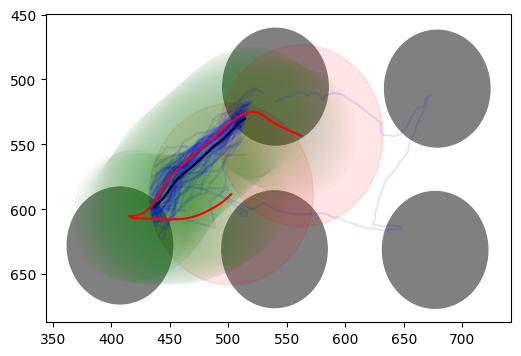

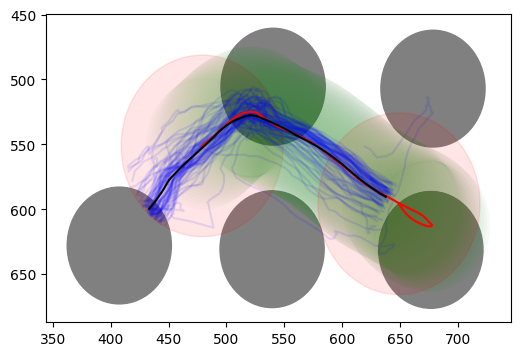

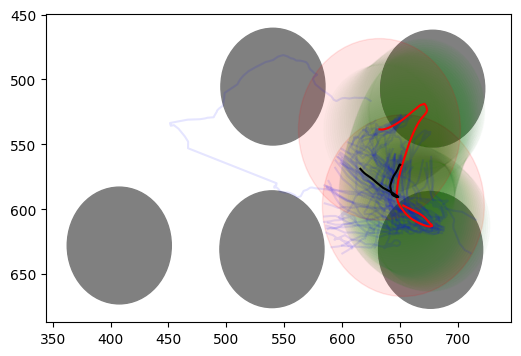

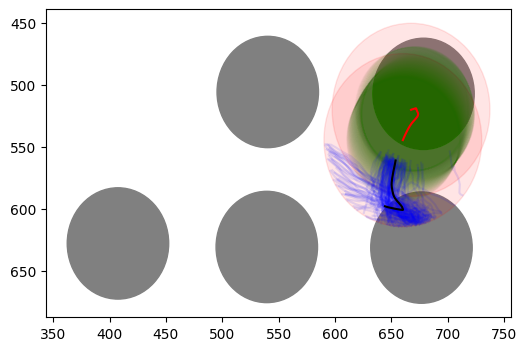

In [434]:

#convert to xy coords
coords = []
for ind_,item in enumerate(current_x):
    coords += [[item,current_y[ind_]]]
    
## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
fps = 1/np.mean(np.diff(camera_timestamps_df['Time Stamps'].values))
time_filter = 4 #in s
frame_filter = int(time_filter / (1/fps))

for i in range(len(motif_start_ends_df)):
    points = []
    for column in list(motif_start_ends_df):
        row = motif_start_ends_df[(f'{column}')][i]
        points += [row]

    radius_intermediate =50  
    radius_start_end = 70
    inds = find_transition_times(points[0], points[-1], points[1:-1], coords, frame_filter,radius_start_end, radius_intermediate,0)
    
    filtered_inds = []
    for ind in inds:
        traject = coords[ind[0]:ind[1]]
        if len(traject) > 10:
            filtered_inds += [ind]
                        
    # filtered_inds = clean_up_trajectories(filtered_inds, coords, points[0], points[-1], points[1:-1], max_deviation=80)

    fig, ax = plt.subplots(1, 1,figsize=(6, 4))
    for index,port_centroid in enumerate(port_centroids):
        circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
        ax.add_patch(circle1)


    for index,centroid in enumerate(points):
        if index == 0 or index == len(points)-1:
            rad,a,c = radius_start_end,0.1,'red'
        else:
            rad,a,c = radius_intermediate,0.01,'green'

        circle2 = plt.Circle(centroid, rad, color=c, alpha = a)
        ax.add_patch(circle2)


    trajects = []
    for ind in filtered_inds:
        traject = coords[ind[0]:ind[1]]
        trajects += [traject]
        x = [point[0] for point in traject]
        y = [point[1] for point in traject]
        ax.plot(x,y,'-', color = 'blue', alpha = 0.1)
            
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    ax.plot(x,y,'-', color = 'red', alpha = 1)
    
    
    av_of_found = interpolate_to_longest_and_find_average_curve(trajects,1000)
    x = [point[0] for point in av_of_found]
    y = [point[1] for point in av_of_found]
    ax.plot(x,y,'-', color = 'k', alpha = 1)
        
    
    
    ax.invert_yaxis()
    
    print(len(filtered_inds))



    
# this is sort of working but not that well. it might be better to use larger circle areas, and some kind of average direction to filter out stuff that on average isnt moving in the right direction... thougb this will be hard with motifs that turn a corner...





In [435]:
points[0]

array([660.19265431, 544.53692667])

In [235]:
a

0.1

Processing segments: 100%|██████████| 164626/164626 [02:26<00:00, 1122.82it/s] 


289


Processing segments: 100%|██████████| 164626/164626 [03:19<00:00, 824.57it/s]  


64


Processing segments: 100%|██████████| 164626/164626 [03:04<00:00, 890.81it/s]  


267


Processing segments: 100%|██████████| 164626/164626 [00:47<00:00, 3480.54it/s] 


108


Processing segments:  22%|██▏       | 36571/164626 [00:23<01:22, 1555.69it/s]


KeyboardInterrupt: 

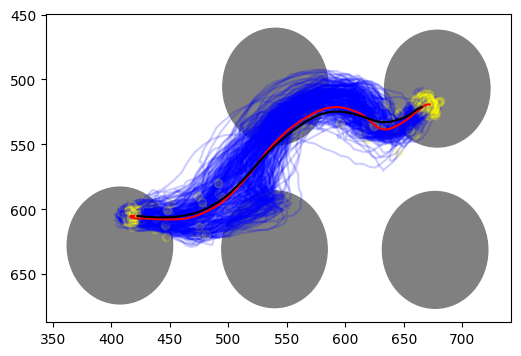

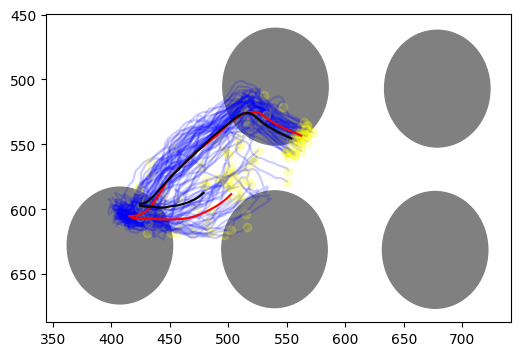

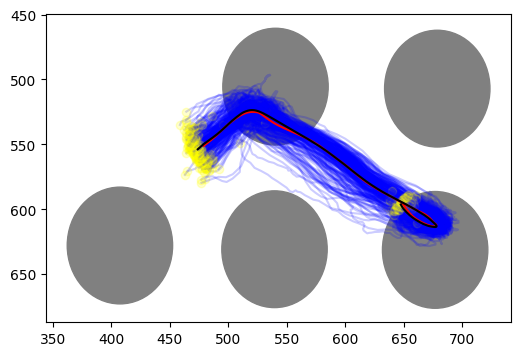

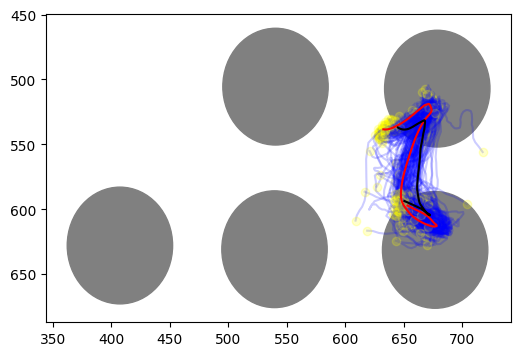

31


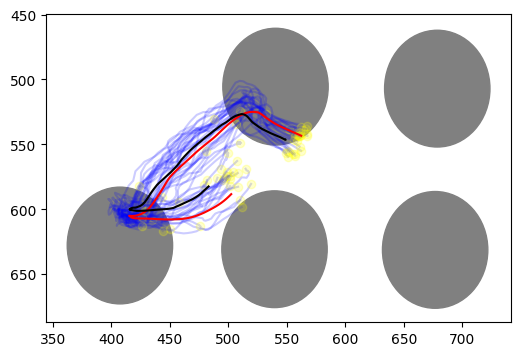

In [660]:
# then remove any duplicates:
valid_trajectories_filtered = remove_overlaps(valid_trajectories)

fig, ax = plt.subplots(1, 1,figsize=(6, 4))
for index,port_centroid in enumerate(port_centroids):
    circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
    ax.add_patch(circle1)

trajects = []
for ind in valid_trajectories_filtered:
    traject = coords[ind[0]:ind[1]]
    trajects += [traject]
    x = [point[0] for point in traject]
    y = [point[1] for point in traject]
    ax.plot(x,y,'-', color = 'blue', alpha = 0.2)
    ax.plot(x[0],y[0],'o', color = 'yellow', alpha = 0.2)
    ax.plot(x[-1],y[-1],'o', color = 'yellow', alpha = 0.2)

x = [point[0] for point in points]
y = [point[1] for point in points]
ax.plot(x,y,'-', color = 'red', alpha = 1)

av_of_found = interpolate_to_longest_and_find_average_curve(trajects,500)
x = [point[0] for point in av_of_found]
y = [point[1] for point in av_of_found]
ax.plot(x,y,'-', color = 'k', alpha = 1)
    
ax.invert_yaxis()

print(len(valid_trajectories_filtered))

262


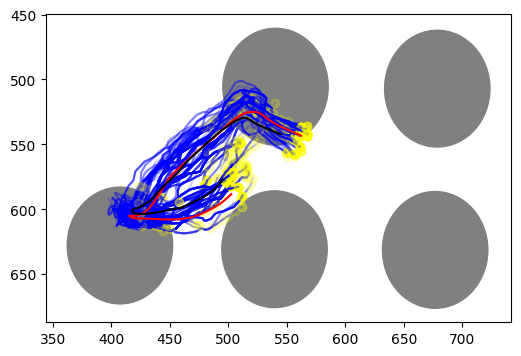

In [657]:
## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
time_filter = 6 #in s
# minimum distance from start/end centroid
dist_filter = 80
# number of closest points to start/end centroid to find and chose from
num_points = 3
# number of points to add to the start and end of the trajectory
add_start_end = 5
valid_trajectories = process_and_validate_trajectories(coords, similar_segments, points,add_start_end,int(time_filter / (1/fps)),dist_filter,num_points)

# then remove any duplicates:


fig, ax = plt.subplots(1, 1,figsize=(6, 4))
for index,port_centroid in enumerate(port_centroids):
    circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
    ax.add_patch(circle1)

trajects = []
for ind in valid_trajectories:
    traject = coords[ind[0]:ind[1]]
    trajects += [traject]
    x = [point[0] for point in traject]
    y = [point[1] for point in traject]
    ax.plot(x,y,'-', color = 'blue', alpha = 0.2)
    ax.plot(x[0],y[0],'o', color = 'yellow', alpha = 0.2)
    ax.plot(x[-1],y[-1],'o', color = 'yellow', alpha = 0.2)

x = [point[0] for point in points]
y = [point[1] for point in points]
ax.plot(x,y,'-', color = 'red', alpha = 1)

av_of_found = interpolate_to_longest_and_find_average_curve(trajects,500)
x = [point[0] for point in av_of_found]
y = [point[1] for point in av_of_found]
ax.plot(x,y,'-', color = 'k', alpha = 1)
    
ax.invert_yaxis()

print(len(valid_trajectories))


In [642]:
len(similar_segments)

507

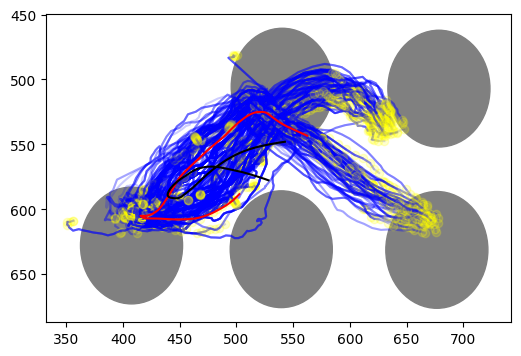

In [643]:

fig, ax = plt.subplots(1, 1,figsize=(6, 4))
for index,port_centroid in enumerate(port_centroids):
    circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
    ax.add_patch(circle1)

trajects = []
for ind in similar_segments:
    traject = coords[ind[0]:ind[1]]
    trajects += [traject]
    x = [point[0] for point in traject]
    y = [point[1] for point in traject]
    ax.plot(x,y,'-', color = 'blue', alpha = 0.2)
    ax.plot(x[0],y[0],'o', color = 'yellow', alpha = 0.2)
    ax.plot(x[-1],y[-1],'o', color = 'yellow', alpha = 0.2)

x = [point[0] for point in points]
y = [point[1] for point in points]
ax.plot(x,y,'-', color = 'red', alpha = 1)

av_of_found = interpolate_to_longest_and_find_average_curve(trajects,500)
x = [point[0] for point in av_of_found]
y = [point[1] for point in av_of_found]
ax.plot(x,y,'-', color = 'k', alpha = 1)
    
ax.invert_yaxis()

In [ ]:
        # Step 5: Check for index overlap
        trimmed_indices = set(range(trimmed_start,trimmed_end))
        
        # If there is an overlap, compare the lengths and keep the longest one
        overlapping_trajectory = None
        for idx, (existing_start, existing_end) in enumerate(processed_trajectories):
            existing_indices = set(range(existing_start, existing_end + 1))
            if trimmed_indices.intersection(existing_indices):
                # Keep the longest trajectory
                if len(trimmed_trajectory) > (existing_end - existing_start + 1):
                    overlapping_trajectory = (trimmed_start + extended_start, trimmed_end + extended_start)
                    processed_trajectories[idx] = overlapping_trajectory  # Replace the shorter one
                else:
                    overlapping_trajectory = (existing_start, existing_end)
                break
        else:
            overlapping_trajectory = (trimmed_start + extended_start, trimmed_end + extended_start)


            all_indices.update(trimmed_indices)

In [ ]:
## take code which finds full sequences from tracking data 
# find average line
# split the data into the different motif areas 
# find the mean variability of each motif area

# number of motifs performed/ time spent doing each motif  



In [51]:
len(similar_segments)

60

In [2]:
### is there a link between behaviour and the replay we see? 

## load all the replay sessions that i have...
## look for a correlation:
# number of trials
# amount of each motif
# how variable each motif is
# number of errors
# reward rate
# others?

# so i need to load the behavioural data to take standard measures
# then take the tracking data to extract variability
# most complicated will be working out how to map the motifs to the task.. 
# # should be okay because I know where on the linearised task thye sit so i just take these positions. 


# do these correlate with replay rate, a characteristic of replay? motif specific replay? 

In [ ]:
## is there a link between replay and behaviour?

# need session before and after - take basic meausures as before 
# I think take same meausures as before 
# does replay predict a change? 
